# Neural Networks For Market Trading

In [ ]:
!pip install xgboost backtesting matplotlib scikit-learn pandas pandas_ta 

In [1]:
import pandas as pd
df = pd.read_csv("dji_30.csv")

#Check if NA values are in data
# df=df[df['volume']!=0]
df.reset_index(drop=True, inplace=True)
df.isna().sum()
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
478,2023-11-28,353.489990,355.140015,353.089996,354.109985,354.109985,2759600
479,2023-11-29,354.970001,356.130005,354.369995,354.649994,354.649994,2736300
480,2023-11-30,356.709991,360.179993,356.450012,360.000000,360.000000,4094300
481,2023-12-01,360.019989,363.250000,359.859985,363.049988,363.049988,5850900
482,2023-12-04,361.149994,362.950012,361.019989,362.640015,362.640015,4211000


# Support and Resistance FUNCTIONS

In [2]:
def support(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.Low[i]>df1.Low[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.Low[i]<df1.Low[i-1]):
            return 0
    return 1

def resistance(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.High[i]<df1.High[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.High[i]>df1.High[i-1]):
            return 0
    return 1

In [3]:
length = len(df)
high = list(df['High'])
low = list(df['Low'])
close = list(df['Close'])
open = list(df['Open'])
bodydiff = [0] * length

highdiff = [0] * length
lowdiff = [0] * length
ratio1 = [0] * length
ratio2 = [0] * length

def isEngulfing(l):
    row=l
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001      

    bodydiffmin = 0.002
    if (bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]<close[row-1] and
        open[row]>close[row] and 
        (open[row]-close[row-1])>=-0e-5 and close[row]<open[row-1]): #+0e-5 -5e-5
        return 1

    elif(bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]>close[row-1] and
        open[row]<close[row] and 
        (open[row]-close[row-1])<=+0e-5 and close[row]>open[row-1]):#-0e-5 +5e-5
        return 2
    else:
        return 0
       
def isStar(l):
    bodydiffmin = 0.0020
    row=l
    highdiff[row] = high[row]-max(open[row],close[row])
    lowdiff[row] = min(open[row],close[row])-low[row]
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001
    ratio1[row] = highdiff[row]/bodydiff[row]
    ratio2[row] = lowdiff[row]/bodydiff[row]

    if (ratio1[row]>1 and lowdiff[row]<0.2*highdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]>close[row]):
        return 1
    elif (ratio2[row]>1 and highdiff[row]<0.2*lowdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]<close[row]):
        return 2
    else:
        return 0
    
def closeResistance(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.High[l]-min(levels, key=lambda x:abs(x-df.High[l])))<=lim
    c2 = abs(max(df.Open[l],df.Close[l])-min(levels, key=lambda x:abs(x-df.High[l])))<=lim
    c3 = min(df.Open[l],df.Close[l])<min(levels, key=lambda x:abs(x-df.High[l]))
    c4 = df.Low[l]<min(levels, key=lambda x:abs(x-df.High[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0
    
def closeSupport(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.Low[l]-min(levels, key=lambda x:abs(x-df.Low[l])))<=lim
    c2 = abs(min(df.Open[l],df.Close[l])-min(levels, key=lambda x:abs(x-df.Low[l])))<=lim
    c3 = max(df.Open[l],df.Close[l])>min(levels, key=lambda x:abs(x-df.Low[l]))
    c4 = df.High[l]>min(levels, key=lambda x:abs(x-df.Low[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0

In [4]:
n1=2
n2=2
backCandles=30
signal = [0] * length

for row in range(backCandles, len(df)-n2):
    ss = []
    rr = []
    for subrow in range(row-backCandles+n1, row+1):
        if support(df, subrow, n1, n2):
            ss.append(df.Low[subrow])
        if resistance(df, subrow, n1, n2):
            rr.append(df.High[subrow])
    #!!!! parameters
    if ((isEngulfing(row)==1 or isStar(row)==1) and closeResistance(row, rr, 150e-5) ):#and df.RSI[row]<30
        signal[row] = 1
    elif((isEngulfing(row)==2 or isStar(row)==2) and closeSupport(row, ss, 150e-5)):#and df.RSI[row]>70
        signal[row] = 2
    else:
        signal[row] = 0



In [5]:
df['signal']=signal

In [6]:
df[df['signal']==1].count()

Date         7
Open         7
High         7
Low          7
Close        7
Adj Close    7
Volume       7
signal       7
dtype: int64

In [7]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,signal
0,2022-01-03,364.339996,365.850006,362.299988,365.679993,352.397278,5624100,0
1,2022-01-04,367.339996,369.209991,367.209991,367.869995,354.507782,5462200,0
2,2022-01-05,367.709991,369.500000,363.980011,364.089996,350.865082,7638000,0
3,2022-01-06,364.109985,364.649994,361.959991,362.390015,349.226746,7019800,0
4,2022-01-07,361.890015,363.869995,361.130005,362.309998,349.149658,5806300,0
...,...,...,...,...,...,...,...,...
478,2023-11-28,353.489990,355.140015,353.089996,354.109985,354.109985,2759600,0
479,2023-11-29,354.970001,356.130005,354.369995,354.649994,354.649994,2736300,0
480,2023-11-30,356.709991,360.179993,356.450012,360.000000,360.000000,4094300,0
481,2023-12-01,360.019989,363.250000,359.859985,363.049988,363.049988,5850900,0


In [8]:
df.columns = ['Date', 'Open', 'High', 'Low', 'Close','Adj Cloe', 'Volume', 'signal']
df=df.iloc[100:200]
df

,Date,Open,High,Low,Close,Adj Cloe,Volume,signal
100,2022-05-26,322.950012,327.769989,322.899994,326.450012,316.877472,3270200,0
101,2022-05-27,327.049988,332.130005,326.820007,332.070007,322.332642,2773100,0
102,2022-05-31,330.170013,332.549988,327.660004,330.200012,320.517548,4354000,0
103,2022-06-01,332.410004,332.950012,326.100006,328.359985,318.731476,3721400,1
104,2022-06-02,328.549988,332.779999,325.359985,332.769989,323.012207,3718800,0
...,...,...,...,...,...,...,...,...
195,2022-10-12,292.459991,294.570007,291.369995,292.160004,285.673981,4378700,0
196,2022-10-13,287.140015,301.730011,286.619995,300.559998,293.887512,7389600,0
197,2022-10-14,302.540009,304.359985,296.190002,296.820007,290.230530,5519400,0
198,2022-10-17,300.890015,303.209991,299.980011,302.059998,295.354187,3555700,0


In [9]:
def SIGNAL():
    return df.signal

In [11]:
#A new strategy needs to extend Strategy class and override its two abstract methods: init() and next().
#Method init() is invoked before the strategy is run. Within it, one ideally precomputes in efficient, 
#vectorized manner whatever indicators and signals the strategy depends on.
#Method next() is then iteratively called by the Backtest instance, once for each data point (data frame row), 
#simulating the incremental availability of each new full candlestick bar.

#Note, backtesting.py cannot make decisions / trades within candlesticks — any new orders are executed on the
#next candle's open (or the current candle's close if trade_on_close=True). 
#If you find yourself wishing to trade within candlesticks (e.g. daytrading), you instead need to begin 
#with more fine-grained (e.g. hourly) data.
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

class MyStrategy(Strategy):
    def init(self):
        # Initialize any parameters or indicators here
        self.sma = self.I(ta.SMA, self.data.Close, 10)  # Example: 10-period Simple Moving Average

    def next(self):
        # Core logic of the strategy goes here
        if crossover(self.data.Close, self.sma):
            # Example: Buy when the close crosses above the 10-period SMA
            self.buy()

# Create a Backtest instance with your strategy
bt = Backtest(data, MyStrategy)

# Run the backtest
bt.run()


/home/ha/Downloads/programs/jupyter/env/lib/python3.10/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

NameError: name 'data' is not defined

In [12]:
from backtesting import Strategy

class MyCandlesStrat(Strategy):  
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next() 
        if self.signal1==2:
            sl1 = self.data.Close[-1] - 600e-4
            tp1 = self.data.Close[-1] + 450e-4
            self.buy(sl=sl1, tp=tp1)
        elif self.signal1==1:
            sl1 = self.data.Close[-1] + 600e-4
            tp1 = self.data.Close[-1] - 450e-4
            self.sell(sl=sl1, tp=tp1)

In [13]:
from backtesting import Backtest

bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)
stat = bt.run()
stat



/tmp/ipykernel_57638/1132592598.py:3: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)


Start                                   100.0
End                                     199.0
Duration                                 99.0
Exposure Time [%]                         2.0
Equity Final [$]                  9924.050492
Equity Peak [$]                       10000.0
Return [%]                          -0.759495
Buy & Hold Return [%]               -6.426715
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.759495
Avg. Drawdown [%]                   -0.759495
Max. Drawdown Duration                   36.0
Avg. Drawdown Duration                   36.0
# Trades                                  2.0
Win Rate [%]                              0.0
Best Trade [%]                           -0.0
Worst Trade [%]                      -0.76433
Avg. Trade [%]                    

In [14]:
!pip3 install backtesting

In [15]:
bt.plot()

/home/ha/Downloads/programs/jupyter/env/lib/python3.10/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/home/ha/Downloads/programs/jupyter/env/lib/python3.10/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p1327', ...)

In [16]:
#Target flexible way
pipdiff = 250*1e-4 #for TP
SLTPRatio = 1 #pipdiff/Ratio gives SL
def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)
        #if ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 2 # bth limits exceeded
        #elif ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 3 #-1 downtrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
        #    trendcat[line] = 1 # uptrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 0 # no trend
        #elif ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 5 # light trend down
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 4 # light trend up
            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

/tmp/ipykernel_57638/999573329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target'] = mytarget(30, df)


<Axes: >

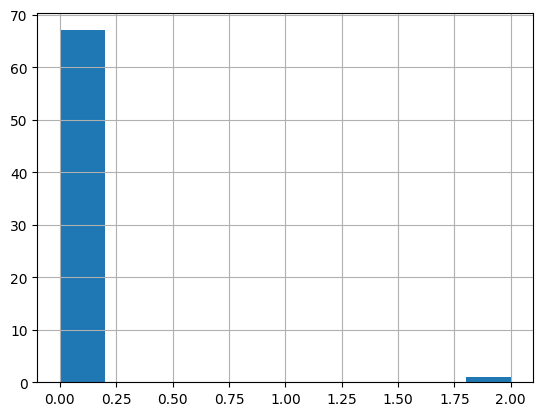

In [17]:
#!!! pitfall one category high frequency
df['Target'] = mytarget(30, df)
#df.tail(20)
#df['Target'] = df['Target'].astype(int)
df['Target'].hist()
# plt.show()  # This line is important to display the plot

In [18]:
%matplotlib inline


In [19]:
import pandas_ta as pa
df["RSI"] = pa.rsi(df.Close, length=16)
df.tail(20)

/tmp/ipykernel_57638/161572885.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["RSI"] = pa.rsi(df.Close, length=16)


,Date,Open,High,Low,Close,Adj Cloe,Volume,signal,Target,RSI
180,2022-09-21,308.519989,310.269989,301.720001,301.809998,295.109711,5110700,0,NaN,32.969519
181,2022-09-22,301.559998,302.970001,299.890015,300.519989,293.848358,3492500,0,NaN,32.094990
182,2022-09-23,297.820007,298.000000,292.399994,295.859985,289.291779,4949300,0,NaN,29.118820
183,2022-09-26,294.600006,296.239990,291.500000,292.720001,286.221558,4143400,0,NaN,27.299358
184,2022-09-27,294.779999,296.529999,289.500000,291.299988,284.833008,3681000,0,NaN,26.500594
185,2022-09-28,292.350006,298.029999,291.049988,296.730011,290.142578,3995700,0,NaN,34.337125
186,2022-09-29,294.769989,294.850006,289.850006,292.209991,285.722900,3351100,0,NaN,31.367590
187,2022-09-30,291.209991,293.459991,287.040009,287.299988,280.921875,3827200,0,NaN,28.510645
188,2022-10-03,290.559998,296.369995,289.470001,294.790009,288.245575,3457600,0,NaN,37.737935
189,2022-10-04,298.609985,303.179993,298.440002,303.140015,296.410187,4163800,0,NaN,46.022638


In [20]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
print(df.describe())

             Open        High         Low       Close    Adj Cloe  \
count   52.000000   52.000000   52.000000   52.000000   52.000000   
mean   320.583271  322.877885  318.659616  321.032499  312.546444   
std     10.898268   10.427647   11.023981   10.548986   10.367268   
min    301.529999  306.470001  301.329987  304.609985  296.361664   
25%    311.447502  314.137489  309.210007  311.487511  303.052971   
50%    319.480011  321.315002  317.220001  319.509995  310.988220   
75%    329.149994  331.052498  327.320000  328.480011  319.718971   
max    340.200012  343.089996  338.970001  341.739990  332.625214   

             Volume     signal  Target        RSI  
count  5.200000e+01  52.000000    52.0  52.000000  
mean   2.954450e+06   0.019231     0.0  52.512773  
std    8.370658e+05   0.138675     0.0  10.854216  
min    1.655100e+06   0.000000     0.0  32.598172  
25%    2.485675e+06   0.000000     0.0  43.836398  
50%    2.895000e+06   0.000000     0.0  52.897259  
75%    3.25090

/home/ha/Downloads/programs/jupyter/env/lib/python3.10/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [21]:
attributes = ['RSI', 'signal', 'Target']
df_model= df[attributes].copy()

df_model['signal'] = pd.Categorical(df_model['signal'])
dfDummies = pd.get_dummies(df_model['signal'], prefix = 'signalcategory')
df_model= df_model.drop(['signal'], axis=1)
df_model = pd.concat([df_model, dfDummies], axis=1)
df_model

,RSI,Target,signalcategory_0,signalcategory_1
0,33.130149,0.0,1,0
1,32.598172,0.0,1,0
2,36.030047,0.0,1,0
3,47.181346,0.0,1,0
4,46.492258,0.0,1,0
5,41.566904,0.0,1,0
6,42.486102,0.0,1,0
7,40.359100,0.0,1,0
8,44.393826,0.0,1,0
9,43.220401,0.0,1,0


In [22]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss

attributes = ['RSI', 'signalcategory_0']
X = df_model[attributes]
y = df_model['Target']

train_pct_index = int(0.7 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

model = XGBClassifier(objective="binary:logistic")
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

[15:54:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
****Train Results****
Accuracy: 100.0000%
****Test Results****
Accuracy: 100.0000%


/home/ha/Downloads/programs/jupyter/env/lib/python3.10/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)
#choices = [2, 0, -1, +1]
##choices = [2, 0, 3, +1]
print(model.get_booster().feature_names)

[[36]]
[[16]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        36

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        16

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

['RSI', 'signalcategory_0']


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


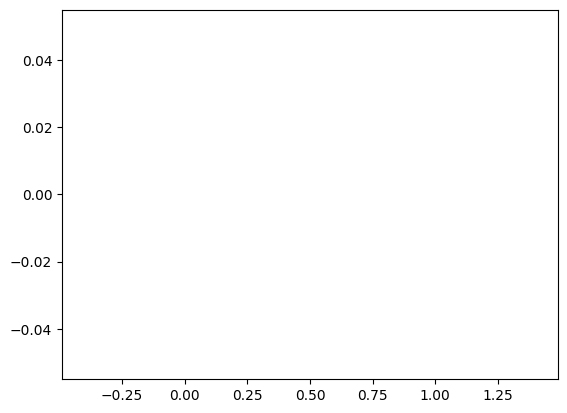

In [29]:
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
print(model)

pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
#plot feature importance
# plot_importance(model, importance_type='weight')
pyplot.show()
# print(model.get_booster().feature_names)

In [31]:
from sklearn.neural_network import MLPClassifier

attributes = ['RSI', 'signalcategory_0']
X = df_model[attributes]
y = df_model['Target']

train_pct_index = int(0.6 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

NN = MLPClassifier(hidden_layer_sizes=(50, 50, 60, 30, 9), random_state=100, verbose=0, max_iter=1000, activation='relu')
NN.fit(X_train, y_train)
pred_train = NN.predict(X_train)
pred_test = NN.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print("="*20)

print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test)) 

****Train Results****
Accuracy: 100.0000%
****Test Results****
Accuracy: 100.0000%


In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)

[[31]]
[[21]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        21

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

